In [34]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

In [19]:
df = pd.read_csv("seismic-bumps.csv")

In [20]:
df.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,hazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,a,a,N,15180,48,-72,-72,a,0,0,0,0,0,0,0,0,0,0,0
1,a,a,N,14720,33,-70,-79,a,1,0,1,0,0,0,0,0,2000,2000,0
2,a,a,N,8050,30,-81,-78,a,0,0,0,0,0,0,0,0,0,0,0
3,a,a,N,28820,171,-23,40,a,1,0,1,0,0,0,0,0,3000,3000,0
4,a,a,N,12640,57,-63,-52,a,0,0,0,0,0,0,0,0,0,0,0


## Feature preprocessing (light)

In [21]:
#remove useless variables from the dataset
column2drop = ['seismoacoustic', 'gdenergy', 'gdpuls', 'hazard','nbumps2', 'nbumps3', 'nbumps4', 'nbumps5', 'nbumps6', 'nbumps7', 'nbumps89', 'energy', 'maxenergy']
df.drop(column2drop, axis=1, inplace=True)

In [22]:
df.head()

,seismic,shift,genergy,gpuls,nbumps,class
0,a,N,15180,48,0,0
1,a,N,14720,33,1,0
2,a,N,8050,30,0,0
3,a,N,28820,171,1,0
4,a,N,12640,57,0,0


In [32]:
###### Lecture Pipeline ######
# you can/have to modify the order for your project,
# e.g. hyperparameter tuning before evaluating a decision tree

# Oversampling
from imblearn.over_sampling import RandomOverSampler

# Hold-out
from sklearn.model_selection import train_test_split

# Decision Tree
from sklearn.tree import DecisionTreeClassifier
# Optional: KNN
from sklearn.neighbors import KNeighborsClassifier

##### Decision Tree Visualization ###
from sklearn import tree # export_graphviz() method
import pydotplus # viz stuff
from IPython.display import Image # viz stuff
####################################

######## Evaluation #######
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
# Optional: baseline comparison
from sklearn.dummy import DummyClassifier
###########################

# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# cross-validation
from sklearn.model_selection import cross_val_score

In [24]:
# Printing categorical first 5 values before pre-processing

print("sesmic's first 5 values: ", df['seismic'].values[:5])
print("shift's first 5 values: ", df['shift'].values[:5])

sesmic's first 5 values:  ['a' 'a' 'a' 'a' 'a']
shift's first 5 values:  ['N' 'N' 'N' 'N' 'N']


In [25]:
# Transform categorical attributes ('seismic' and 'shift') into numerical ones 

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df['seismic'] = le.fit_transform(df['seismic'])
df['shift'] = le.fit_transform(df['shift'])

In [26]:
# Printing categorical first 5 values after pre-processing

print("sesmic's first 5 values: ", df['seismic'].values[:5])
print("shift's first 5 values: ", df['shift'].values[:5])

sesmic's first 5 values:  [0 0 0 0 0]
shift's first 5 values:  [0 0 0 0 0]


## APPLYING CLASSIFICATION

In [27]:
# Spliting dataset into training-set and test-set using HOLD-OUT method

attributes = [col for col in df.columns if col != 'class']
X = df[attributes].values
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

In [28]:
# Printing the shape of dataset, training-set and test-set ([number_of_rows], [number_of_columns])

df.shape, X_train.shape, X_test.shape

((2584, 6), (1808, 5), (776, 5))

In [35]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 1689, 1: 1689})


In [38]:
# Applying the classification algorithm with some parameters

clf = DecisionTreeClassifier(criterion='gini',
                             max_depth=None,
                             min_samples_split=10,
                             min_samples_leaf=5,
                            )

clf.fit(X_res, y_res)

DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=10)

In [39]:
param_list = {'max_depth': [None] + [2, 3, 4],
             'min_samples_split': [2, 5, 10, 20],
             'min_samples_leaf': [1, 5, 10, 20]
             }

grid_search = GridSearchCV(clf, param_grid=param_list, scoring='recall')
grid_search.fit(X, y)

res = grid_search.cv_results_


def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
report(res, n_top=3)

Model with rank: 1
Mean validation score: 0.253 (std: 0.347)
Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20}

Model with rank: 1
Mean validation score: 0.253 (std: 0.348)
Parameters: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 10}

Model with rank: 3
Mean validation score: 0.247 (std: 0.336)
Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}

Model with rank: 3
Mean validation score: 0.247 (std: 0.351)
Parameters: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}

Model with rank: 3
Mean validation score: 0.247 (std: 0.351)
Parameters: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5}



In [40]:
# Priting the attibutes in order of importance according to the classification algorithm applied

imp_dict = {attr: clf.feature_importances_[i] for i, attr in enumerate(attributes)}
imp_dict

{k: v for k, v in sorted(imp_dict.items(), key=lambda item: item[1], reverse=True)}

{'gpuls': 0.40481627248473806,
 'genergy': 0.32607115617461224,
 'nbumps': 0.22105866697429494,
 'seismic': 0.02406537276621824,
 'shift': 0.02398853160013652}

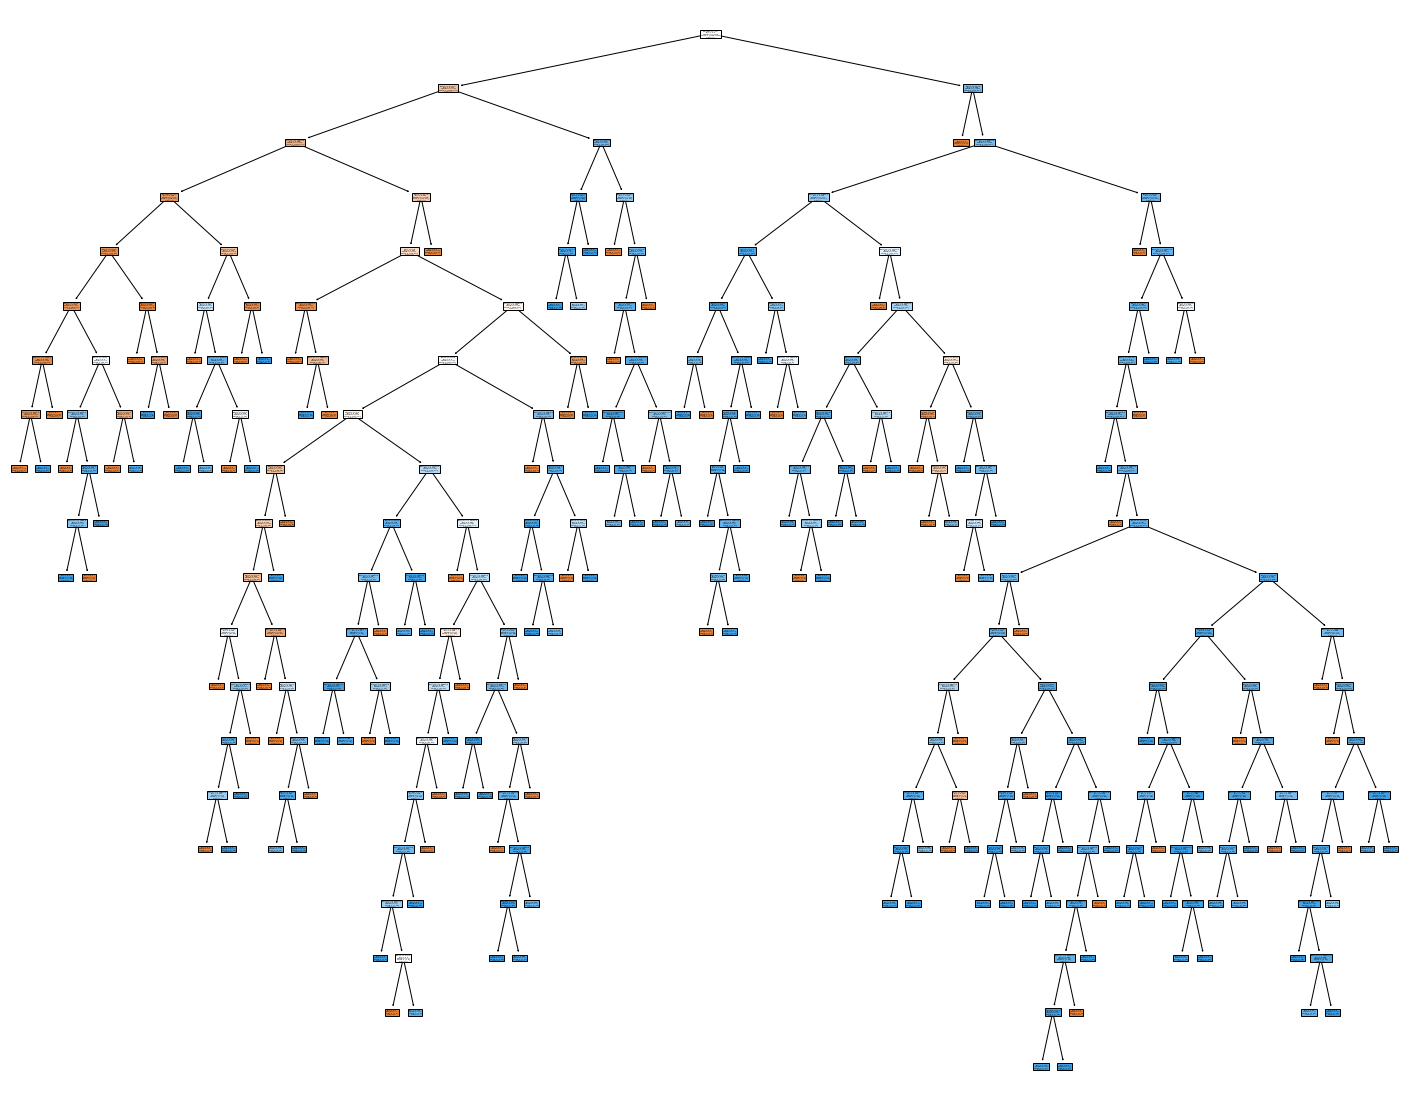

In [41]:
# Plotting the entire Decision Tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=attributes,  
                   class_names=[str(v) for v in clf.classes_],
                   filled=True)

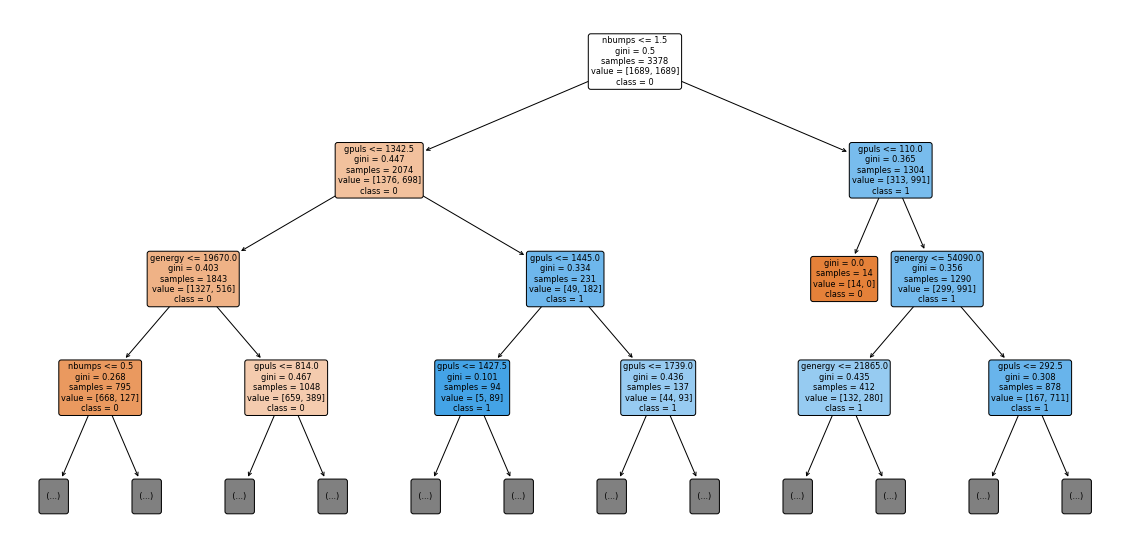

In [42]:
# Plotting only the first 3 levels of the DT

fig = plt.figure(figsize=(20,10))
_ = tree.plot_tree(clf, 
                   feature_names=attributes,  
                   class_names=[str(v) for v in clf.classes_],
                   filled=True, 
                   rounded=True,
                   max_depth=3)

## MODEL EVALUATION

In [43]:
# Applying the model to the training-set

y_pred = clf.predict(X_train)

In [44]:
# Printing the 'Accuracy' and 'F1' values for evaluate the quality of the prediction on the training-set

print('Accuracy', accuracy_score(y_train, y_pred))
print('F1', f1_score(y_train, y_pred, average=None))

Accuracy 0.9574115044247787
F1 [0.97667374 0.75555556]


In [45]:
# Printing other evaluation indences

print( classification_report(y_train, y_pred) )

              precision    recall  f1-score   support

           0       1.00      0.95      0.98      1689
           1       0.61      1.00      0.76       119

    accuracy                           0.96      1808
   macro avg       0.80      0.98      0.87      1808
weighted avg       0.97      0.96      0.96      1808



In [46]:
# Printing of confusion_matrix as seen in the lecture

cf = confusion_matrix(y_train, y_pred, labels=[1,0])
cf

array([[ 119,    0],
       [  77, 1612]])

In [47]:
# TP, FN, FP, TN
cf[0][0], cf[0][1], cf[1][0], cf[1][1]

(119, 0, 77, 1612)

In [48]:
cf = confusion_matrix(y_train, y_pred, labels=[1,0], normalize='all')
cf

array([[0.06581858, 0.        ],
       [0.0425885 , 0.89159292]])

In [49]:
# Applying the model to the test-set (default threshold = 0.5)

y_pred = clf.predict( X_test )

y_pred[:5]

array([0, 0, 0, 0, 0])

In [50]:
# Here the output is not a single value, but pair of value 
# [probability to belong to class '0', prob. to belong to class to belong to class '1']

y_score = clf.predict_proba(X_test)
y_score[:6]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [51]:
# Printing of AUC value (aka Area under the ROC)

fpr, tpr, th = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)

0.583394185260311


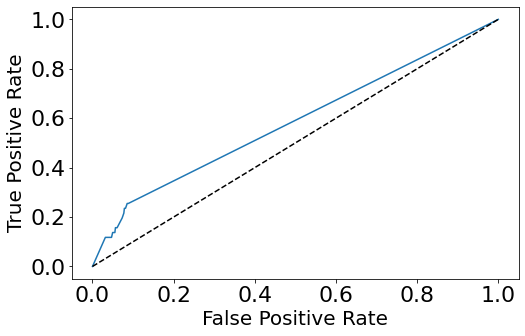

In [52]:
# Plotting of ROC Curve

plt.figure(figsize=(8,5))

plt.plot(fpr, tpr)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [53]:
dummy_clf = DummyClassifier(strategy='constant', constant=1)
dummy_clf.fit(X_test, y_test)

y_pred = dummy_clf.predict(X_test)

In [54]:
cf = confusion_matrix(y_test, y_pred, labels=[1,0])
cf

array([[ 51,   0],
       [725,   0]])

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       725
           1       0.07      1.00      0.12        51

    accuracy                           0.07       776
   macro avg       0.03      0.50      0.06       776
weighted avg       0.00      0.07      0.01       776



/Users/davide/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davide/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davide/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
param_list = {'max_depth': [None] + [2, 3, 4],
             'min_samples_split': [2, 5, 10, 20],
             'min_samples_leaf': [1, 5, 10, 20]
             }

grid_search = GridSearchCV(clf, param_grid=param_list, scoring='f1')
grid_search.fit(X, y)

res = grid_search.cv_results_
res

In [ ]:
grid_search.best_estimator_

In [ ]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
report(res, n_top=3)

In [ ]:
scores = cross_val_score(clf, X, y, cv=10, scoring='f1')

scores.mean(), scores.std()

In [ ]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X, y)